In [4]:
# import os
# import numpy as np
# import pandas as pd
# import sys
# import pyviscous

# def calculate_sensitivity_for_grid_point(params, kge):
#     # Temporary suppress print statements
#     original_stdout = sys.stdout  # Save a reference to the original standard output
#     sys.stdout = open(os.devnull, 'w')  # Redirect standard output to null device
    
#     x = params
#     y = kge
#     ind = ~np.isnan(y)
#     x, y = x[ind, :], y[ind]
#     y = y[:, np.newaxis]
#     nparam = x.shape[1]  # Number of parameters
#     sens_indx_first = np.zeros(nparam)

#     for xIndex in range(nparam): 
#         sens_indx_first[xIndex], _ = pyviscous.viscous(x, y, xIndex, 'first', MSC='AIC', verbose=False) 

#     # Restore print functionality
#     sys.stdout.close()
#     sys.stdout = original_stdout  # Reset the standard output to its original value

#     return sens_indx_first

# def process_basin(basin_index):
#     print(f'Processing basin: {basin_index}')
#     outfile = f'sens_{basin_index}.npz'

#     if os.path.isfile(outfile):
#         print(f'Loading sensitivity for basin {basin_index} from {outfile}.')
#         dtmp = np.load(outfile)
#         sens = dtmp['sens']
#         param_file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin_index}_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv'
#         df_param = pd.read_csv(param_file)
#     else:
#         # Construct file paths
#         param_file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin_index}_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv'
#         metric_file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin_index}_MOASMOcalib/ctsm_outputs/iter0_many_metric.csv'
        
#         # Read the parameter and metric files
#         df_param = pd.read_csv(param_file)
#         df_metric = pd.read_csv(metric_file)
    
#         # Extract params and kge
#         params = df_param.values
#         if 'precip_repartition_nonglc_all_rain_t' in df_metric.columns:
#             mask = []
#             for c in df_metric.columns:
#                 if ('precip' in c) and (c != 'precip_repartition_nonglc_all_rain_t'):
#                     mask.append(False)
#                 else:
#                     mask.append(True)
#             mask = np.array(mask)
#             params = params[:, mask]
        
#         kge = df_metric['kge'].values
    
#         # Calculate sensitivity for the current basin
#         sens = calculate_sensitivity_for_grid_point(params, kge)
#         np.savez_compressed(outfile, sens=sens)
        
#     return basin_index, sens, df_param.columns.tolist()

# if __name__ == "__main__":

#     # basin_index = int(sys.argv[1])
#     basin_index = 0
    
#     # Process the specified basin
#     basin_index, sens, param_names = process_basin(basin_index)

#     # Output the results for the specified basin
#     print(f"Completed processing for basin {basin_index}.")
#     print("Sensitivity values:", sens)


In [14]:
import os
import numpy as np
import pandas as pd
import sys
import pyviscous
from concurrent.futures import ProcessPoolExecutor, as_completed

def calculate_sensitivity_for_grid_point(params, kge):
    # Temporary suppress print statements
    original_stdout = sys.stdout  # Save a reference to the original standard output
    sys.stdout = open(os.devnull, 'w')  # Redirect standard output to null device
    
    x = params
    y = kge
    ind = ~np.isnan(y)
    x, y = x[ind, :], y[ind]
    y = y[:, np.newaxis]
    nparam = x.shape[1]  # Number of parameters
    sens_indx_first = np.zeros(nparam)

    for xIndex in range(nparam): 
        sens_indx_first[xIndex], _ = pyviscous.viscous(x, y, xIndex, 'first', MSC='AIC', verbose=False) 

    # Restore print functionality
    sys.stdout.close()
    sys.stdout = original_stdout  # Reset the standard output to its original value

    return sens_indx_first

def process_basin(basin_index):
    print(f'Processing basin: {basin_index}')
    outfile = f'sens_{basin_index}.npz'

    if os.path.isfile(outfile):
        print(f'Loading sensitivity for basin {basin_index} from {outfile}.')
        dtmp = np.load(outfile)
        sens = dtmp['sens']
        param_file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin_index}_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv'
        df_param = pd.read_csv(param_file)
        paramnames = np.array(df_param.columns)

        # if 'precip_repartition_nonglc_all_rain_t' in df_metric.columns:
        #     mask = []
        #     for c in df_param.columns:
        #         if ('precip' in c) and (c != 'precip_repartition_nonglc_all_rain_t'):
        #             mask.append(False)
        #         else:
        #             mask.append(True)
        #     mask = np.array(mask)
        #     paramnames = paramnames[mask]
    
    else:
        # Construct file paths
        param_file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin_index}_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv'
        metric_file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_{basin_index}_MOASMOcalib/ctsm_outputs/iter0_many_metric.csv'
        
        # Read the parameter and metric files
        df_param = pd.read_csv(param_file)
        df_metric = pd.read_csv(metric_file)
        paramnames = np.array(df_param.columns)
    
        # Extract params and kge
        params = df_param.values
        if 'precip_repartition_nonglc_all_rain_t' in paramnames:
            mask = []
            for c in df_metric.columns:
                if ('precip' in c) and (c != 'precip_repartition_nonglc_all_rain_t'):
                    mask.append(False)
                else:
                    mask.append(True)
            mask = np.array(mask)
            params = params[:, mask]
            paramnames = paramnames[mask]
        
        kge = df_metric['kge'].values
    
        # Calculate sensitivity for the current basin
        sens = calculate_sensitivity_for_grid_point(params, kge)
        np.savez_compressed(outfile, sens=sens)
        
    return basin_index, sens, paramnames



In [24]:

    # Use ProcessPoolExecutor to run calculations in parallel with 128 workers
    num_workers = 1

    all_sensitivities = []
    all_param_names = []

    # with ProcessPoolExecutor(max_workers=num_workers) as executor:
    #     futures = {executor.submit(process_basin, i): i for i in range(627)}

    #     for future in as_completed(futures):
    #         basin_index, sens, param_names = future.result()
    #         all_sensitivities.append(sens)
    #         all_param_names.update(param_names)

    for i in range(627):
        basin_index, sens, param_names = process_basin(i)
        all_sensitivities.append(sens)
        all_param_names.append(param_names)

Processing basin: 0
Loading sensitivity for basin 0 from sens_0.npz.
Processing basin: 1
Loading sensitivity for basin 1 from sens_1.npz.
Processing basin: 2
Loading sensitivity for basin 2 from sens_2.npz.
Processing basin: 3
Loading sensitivity for basin 3 from sens_3.npz.
Processing basin: 4
Loading sensitivity for basin 4 from sens_4.npz.
Processing basin: 5
Loading sensitivity for basin 5 from sens_5.npz.
Processing basin: 6
Loading sensitivity for basin 6 from sens_6.npz.
Processing basin: 7
Loading sensitivity for basin 7 from sens_7.npz.
Processing basin: 8
Loading sensitivity for basin 8 from sens_8.npz.
Processing basin: 9
Loading sensitivity for basin 9 from sens_9.npz.
Processing basin: 10
Loading sensitivity for basin 10 from sens_10.npz.
Processing basin: 11
Loading sensitivity for basin 11 from sens_11.npz.
Processing basin: 12
Loading sensitivity for basin 12 from sens_12.npz.
Processing basin: 13
Loading sensitivity for basin 13 from sens_13.npz.
Processing basin: 14
L

In [39]:
# check precip senst
dd = []
for i in range(627):
    if 'precip_repartition_nonglc_all_rain_t' in all_param_names[i]:
        ind = np.array([s.startswith('precip') for s in all_param_names[i]])
        dd.append(all_sensitivities[i][ind])

dd = np.array(dd)
np.nanmean(dd, axis=0), np.nanmedian(dd, axis=0)

(array([-10.20540233, -10.20581315, -10.20599522, -10.20648501]),
 array([0.00519742, 0.00464798, 0.00486301, 0.00502035]))

In [66]:
# Get unique parameter names
unique_param_names = set()
for params in all_param_names:
    unique_param_names.update(params)

# Convert to a NumPy array
unique_param_names = np.array(list(unique_param_names))

# Initialize the array for all sensitivities
array_all_sensitivities = np.nan * np.zeros((len(all_sensitivities), len(unique_param_names)))

# Populate the array with sensitivity values
for i in range(len(all_sensitivities)):
    parami = all_param_names[i]
    for j in range(len(parami)):
        indij = np.where(unique_param_names == parami[j])[0]
        if indij.size > 0:  # Ensure index exists
            array_all_sensitivities[i, indij[0]] = all_sensitivities[i][j]  # Get the first index


In [76]:
df_first_senst = pd.DataFrame(array_all_sensitivities, columns = unique_param_names)
df_first_senst.to_csv('CAMELS_627_firstorder_senst.csv', index=False)

In [98]:
df2 = df_first_senst.drop('precip_repartition_glc_all_snow_t', axis=1)
df2 = df2.drop('precip_repartition_nonglc_all_snow_t', axis=1)
df2 = df2.drop('precip_repartition_glc_all_rain_t', axis=1)

allranks = np.nan * df2.values

for i in range(array_all_sensitivities.shape[0]):
    arr =  df2.values[i,:]

    # Get the ranks, ignoring NaNs
    sorted_indices = np.argsort(-arr, kind='mergesort')  # Sort in descending order
    ranks = np.zeros(len(sorted_indices))  # Create an empty array for ranks
    ranks[sorted_indices] = np.arange(len(arr))  # Assign ranks based on sorted indices
    
    # Set ranks of NaN values to NaN
    ranks[np.isnan(arr)] = np.nan

    allranks[i,:] = ranks

print(df2.columns)
print(np.nanmean(allranks, axis=0))

Index(['zbedrock', 'n_baseflow', 'precip_repartition_nonglc_all_rain_t',
       'bsw_sf', 'd_max', 'interception_fraction', 'leafcn', 'cv',
       'upplim_destruct_metamorph', 'medlynslope', 'FMAX', 'om_frac_sf',
       'accum_factor', 'watsat_sf', 'n_melt_coef',
       'maximum_leaf_wetted_fraction', 'slopebeta', 'fff', 'jmaxb0', 'kmax',
       'hksat_sf', 'e_ice', 'baseflow_scalar', 'zsno', 'sucsat_sf',
       'liq_canopy_storage_scalar'],
      dtype='object')
[ 6.38068182 10.77160494  7.66666667  6.46052632  6.93333333  8.59187279
  7.4040404   9.18539326  8.62151394  5.61562998  6.16108453  6.19607843
  6.14285714  1.25043478  6.91495601 10.83495146  7.07758621  3.14354067
  8.4902439   8.85390428  5.96331738  6.342      11.         10.6730038
  6.39872408  7.16744186]


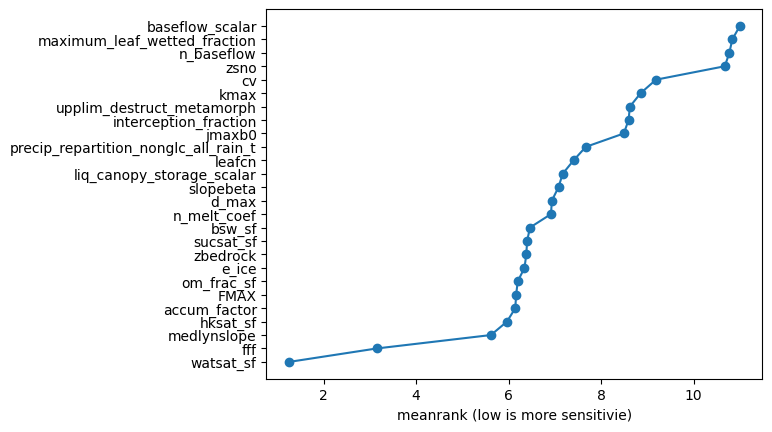

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] Index(['watsat_sf', 'fff', 'medlynslope', 'hksat_sf', 'accum_factor', 'FMAX',
       'om_frac_sf', 'e_ice', 'zbedrock', 'sucsat_sf', 'bsw_sf', 'n_melt_coef',
       'd_max', 'slopebeta', 'liq_canopy_storage_scalar', 'leafcn',
       'precip_repartition_nonglc_all_rain_t', 'jmaxb0',
       'interception_fraction', 'upplim_destruct_metamorph', 'kmax', 'cv',
       'zsno', 'n_baseflow', 'maximum_leaf_wetted_fraction',
       'baseflow_scalar'],
      dtype='object')


In [112]:
meanrank = np.nanmean(allranks,axis=0)
ind = np.argsort(meanrank)
plt.plot(meanrank[ind], df2.columns[ind], '-o')
plt.xlabel('meanrank (low is more sensitivie)')
plt.show()

print(np.arange(len(df2.columns[ind])), df2.columns[ind])


In [121]:
parameter_list = [
    'fff',
    'e_ice',
    'd_max',
    'FMAX',
    'om_frac_sf',
    'interception_fraction',
    'watsat_sf',
    'sucsat_sf',
    'bsw_sf',
    'zbedrock',
    'hksat_sf',
    'baseflow_scalar',
    'n_baseflow',
    'slopebeta',
    'liq_canopy_storage_scalar',
    'maximum_leaf_wetted_fraction',
    'n_melt_coef',
    'accum_factor',
    'upplim_destruct_metamorph',
    'zsno',
    'precip_repartition_nonglc_all_rain_t',
    'medlynslope',
    'jmaxb0',
    'kmax',
    'cv',
    'taulnir',
    'leafcn'
]

i2 = np.arange(len(df2.columns[ind]))
p2 = df2.columns[ind]
for p in parameter_list:
    if p in p2:
        print(p, i2[np.where(p2 == p)[0][0]])
    else:
        print(p, -999)

fff 1
e_ice 7
d_max 12
FMAX 5
om_frac_sf 6
interception_fraction 18
watsat_sf 0
sucsat_sf 9
bsw_sf 10
zbedrock 8
hksat_sf 3
baseflow_scalar 25
n_baseflow 23
slopebeta 13
liq_canopy_storage_scalar 14
maximum_leaf_wetted_fraction 24
n_melt_coef 11
accum_factor 4
upplim_destruct_metamorph 19
zsno 22
precip_repartition_nonglc_all_rain_t 16
medlynslope 2
jmaxb0 17
kmax 20
cv 21
taulnir -999
leafcn 15


In [117]:
i2

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),)